In [15]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [19]:
!cd gdrive/MyDrive/

In [20]:
!ls

budapest_connectome_3.0_209_0_median_20k.csv	 gdrive
budapest_connectome_3.0_209_0_median_fc_20k.csv  sample_data


In [2]:
!pip install jitcdde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jitcdde: filename=jitcdde-1.8.1-py3-none-any.whl size=55003 sha256=750d9f673ed7145b3ccadd7c7b5eed042dc5667e1a5b1e78e23e660019d720a4
  Stored in directory: /root/.cache/pip/wheels/42/e3/4e/94b61188e5e3e62ba27e9586da5ecc7ea0f24e26916a250cc7
  Created wheel for chspy: filename=CHSPy-1.2.2-py3-none-any.whl size=11999 sha256=94891ad5c0c1c35129a75eefce0ea00b3d34f7ca626dc04fc6491a468d378c15
  Stored in directory: /root/.cache/pip/wheels/11/17/24/0cca70842afd051f54325b813e637d8e8836d88c286ba63fae
  Created wheel for jitcxde_common: filename=jitcxde_common-1.5.4-py3-none-any.whl size=16755 sha256=d881ca0a8986ef213bc36cee270cb665a6c9461feabe1f35911fd21ef095d047
  Stored in directory: /root/.cach

In [4]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from jitcdde import jitcdde, y, t
from numpy import pi, arange, random, max
from symengine import sin

In [21]:
count_file_path = "gdrive/MyDrive/PBM-report2/budapest_connectome_3.0_209_0_median_fc_20k.csv"
length_file_path = "gdrive/MyDrive/PBM-report2/budapest_connectome_3.0_209_0_median_20k.csv"

In [68]:
def get_weights_of_nodes(count_file_path, length_file_path):
    df_count = pd.read_csv(count_file_path, delimiter=';')
    df_len = pd.read_csv(length_file_path, delimiter=';')

    df_merged = pd.merge(df_count, df_len, how='inner',
                     left_on=['parent id node1', 'parent id node2'],
                     right_on=['parent id node1', 'parent id node2'])

    df_merged = df_merged[['parent id node1', 'parent id node2', 'edge weight(med nof)', 'edge weight(med flm)']]
    df_merged = df_merged.rename(columns={'parent id node1':'node1', 'parent id node2':'node2', 'edge weight(med nof)':'fiber_count', 'edge weight(med flm)':'fiber_length'})

    l = df_merged["node1"].astype('int')
    print(f"Max node id{max(l)}")

    # Extract the necessary information
    nodes = np.union1d(df_merged['node1'].values, df_merged['node2'].values)
    num_nodes = len(nodes)
    edges = list(zip(df_merged['node1'], df_merged['node2']))

    print(f"# nodes:{num_nodes}, # edges:{len(edges)}")

    # Create a mapping from node ID to index
    node_to_index = {node_id: index for index, node_id in enumerate(nodes)}

    w_kj = np.zeros((num_nodes, num_nodes))


    for _, row in df_merged.iterrows():
        idx1 = node_to_index[row['node1']]
        idx2 = node_to_index[row['node2']]
        weight = row['fiber_count']/row['fiber_length']
        w_kj[idx1, idx2] = weight
        w_kj[idx2, idx1] = weight

    return df_merged, w_kj, num_nodes, node_to_index

Max node id83
# nodes:76, # edges:11288


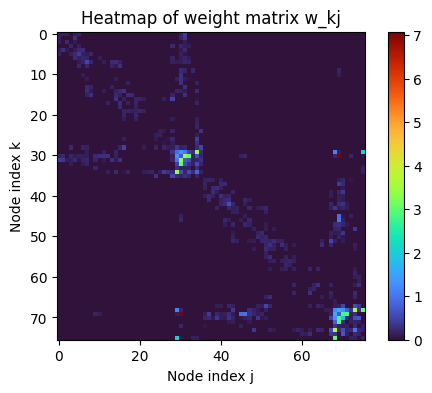

In [69]:
data, w_kj, num_nodes, node_to_index = get_weights_of_nodes(count_file_path, length_file_path)

# Plotting the heatmap
plt.figure(figsize=(6, 4))
heatmap = plt.imshow(w_kj, cmap='turbo')
plt.colorbar(heatmap)
plt.title('Heatmap of weight matrix w_kj')
plt.xlabel('Node index j')
plt.ylabel('Node index k')
plt.show()

In [39]:
data.head()

,node1,node2,fiber_count,fiber_length
0,9,37,25.0,22.239342
1,9,37,25.0,26.385718
2,9,37,25.0,36.416003
3,9,37,25.0,32.376669
4,9,37,25.0,27.144929


In [56]:
w_kj.shape


(76, 76)

Min:7.733333333333333, Max:32.79998666666666


<Axes: xlabel='delay', ylabel='Density'>

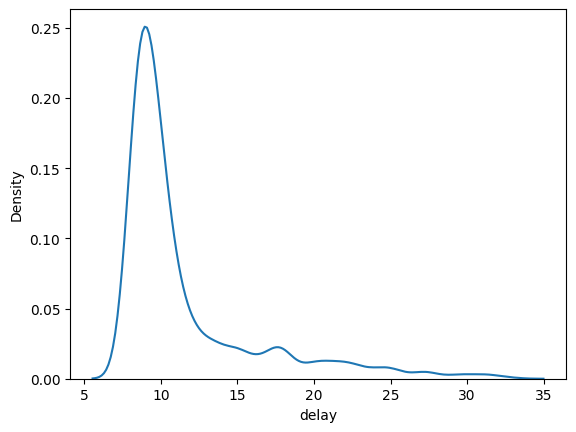

In [63]:
data['delay'] = data['fiber_length'] / 1.5
print(f"Min:{data['delay'].min()}, Max:{data['delay'].max()}")
sns.kdeplot(data, x="delay")

In [66]:
data['delay_interval'] = pd.qcut(data['delay']/1000, q=40)
# for i in range(len(data['delay_interval'].unique())):
#   print(f"{i}:{data['delay_interval'].unique()[i]}")

# Calculate midpoints
midpoints = data['delay_interval'].apply(lambda x: x.mid).unique()

# Map each interval to its midpoint
interval_to_midpoint = {interval: interval.mid for interval in data['delay_interval'].unique()}
data['delay_discrete'] = data['delay_interval'].map(interval_to_midpoint).astype(float)
data.head()

,node1,node2,fiber_count,fiber_length,delay,delay_interval,delay_discrete
0,9,37,25.0,22.239342,14.826228,"(0.0148, 0.016]",0.0154
1,9,37,25.0,26.385718,17.590479,"(0.0175, 0.0183]",0.0179
2,9,37,25.0,36.416003,24.277335,"(0.0227, 0.0255]",0.0241
3,9,37,25.0,32.376669,21.584446,"(0.0205, 0.0227]",0.0216
4,9,37,25.0,27.144929,18.096619,"(0.0175, 0.0183]",0.0179


In [67]:
grouped = data.groupby(['node1', 'node2'])['delay_discrete'].agg(['count', 'mean']).reset_index()
# print(grouped.describe())
grouped.head(10)

,node1,node2,count,mean
0,1,1,25,0.012219
1,1,4,1,0.008445
2,1,5,81,0.012016
3,1,7,25,0.012850
4,1,8,1,0.010400
5,1,36,9,0.016450
6,1,37,121,0.014542
7,4,7,25,0.008903
8,4,36,16,0.010596
9,4,37,4,0.017400


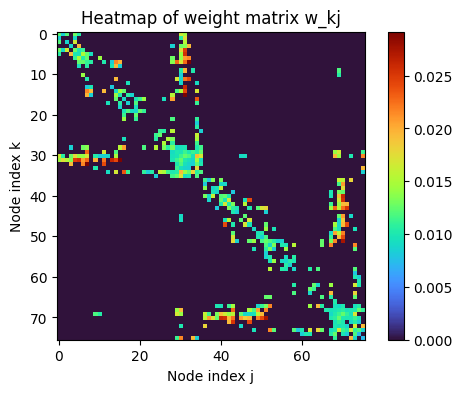

In [70]:
tau_kj = np.zeros((num_nodes, num_nodes))

for _, row in grouped.iterrows():
    idx1 = node_to_index[row['node1']]
    idx2 = node_to_index[row['node2']]

    weight = row['mean']
    tau_kj[idx1, idx2] = weight
    tau_kj[idx2, idx1] = weight

# Plotting the heatmap
plt.figure(figsize=(6, 4))
heatmap = plt.imshow(tau_kj, cmap='turbo')
plt.colorbar(heatmap)
plt.title('Heatmap of weight matrix w_kj')
plt.xlabel('Node index j')
plt.ylabel('Node index k')
plt.show()

In [25]:


# n = 100
n = num_nodes
ω = 1
c = 42
# q = 0.05
# A = random.choice( [1,0], size=(n,n), p=[q,1-q] )
A = w_kj
# τ = random.uniform( pi/5, 2*pi, size=(n,n) )
τ = tau_kj

def kuramotos():
	for i in range(n):
		yield ω + c/(n-1)*sum(
					sin(y(j,t-τ[i,j])-y(i))
					for j in range(n)
					if A[j,i]
				)

I = jitcdde(kuramotos,n=n,verbose=False,delays=τ.flatten())
I.set_integration_parameters(rtol=0,atol=1e-5)

I.constant_past( random.uniform(0,2*pi,n), time=0.0 )
I.integrate_blindly( max(τ) , 0.1 )

# for time in I.t + arange(0,400,0.2):
	# print(*I.integrate(time) % (2*pi))

array([12.62759248,  9.91306241,  9.49723991,  7.48604329,  9.40043551,
       11.56827877,  5.07063257, 10.83642646,  1.62916866, 11.18796458,
        5.96221469,  5.5205554 , 11.14383025,  8.7340655 ,  5.92718553,
        7.86901723, 11.80368304,  8.81868932,  4.54198527,  8.77750993,
        8.4010231 ,  9.68278277,  6.41630529,  9.38228571,  2.39993841,
        8.37385884,  4.14997804,  2.92611757,  9.30910159,  7.01035009,
       11.66479952,  5.68785772,  4.21011869,  8.03705548,  9.94197071,
        7.66679129,  7.63205338,  4.8926038 ,  8.09506489,  4.56077514,
        3.79368078,  9.09947563,  5.88049669, 10.76629951,  9.54058595,
        6.26946718,  6.58449273,  8.80597311,  8.87097066,  7.40490328,
        9.9495411 ,  8.56395114,  3.14900522,  4.0047898 ,  6.73890863,
        8.20568185,  2.80013809,  9.56618856,  8.08108817,  4.4385386 ,
        8.9531196 ,  8.55116331,  6.25643266,  7.53076119,  3.99259064,
       11.90839767,  7.81497439,  4.29894665,  2.77483733,  9.95